# Itility assessment Roman Nekrasov
Onderstaand worden in niet chronologische volgorde de eerste drie vragen van het assessment beantwoord. Eerst wordt een verkennende data analyse uitgevoerd en de data schoongemaakt. Hierna wordt gekeken welke VMs oversized zijn en verlaagd kunnen worden. 

## Importeer libraries en data

In [1]:
# imports and setup 
import pandas as pd
import scipy as sc
import numpy as np
import seaborn as sns


#%matplotlib notebook
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6)

In [31]:
# Run when on Collab
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv("/content/drive/MyDrive/Itility data/testcase_serverdata V3.0 100618.csv", sep=';', decimal=",")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# Run when local
data = pd.read_csv("/Data/testcase_serverdata V3.0 100618.csv", sep=';', decimal=",")

In [22]:
data.head()

,VMName,Cluster,time,AvgValue,MinValue,MaxValue,MetricId,MemoryMB,CpuMHz,NumCpu
0,ITLT4301,1,1-5-2018,9.764394e+05,53842.654537,3.235865e+06,MemActive,4096,0,0
1,ITLT4301,1,1-5-2018,9.894437e+01,29.343545,6.730676e+02,CpuUsageMHz,0,5600,2
2,ITLT4301,1,2-5-2018,1.068048e+06,66663.032845,3.238429e+06,MemActive,4096,0,0
3,ITLT4301,1,2-5-2018,1.146710e+02,30.260531,8.408760e+02,CpuUsageMHz,0,5600,2
4,ITLT4301,1,3-5-2018,9.245217e+05,56406.546801,3.371761e+06,MemActive,4096,0,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440588 entries, 0 to 440587
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   VMName    440588 non-null  object 
 1   Cluster   440588 non-null  int64  
 2   time      440588 non-null  object 
 3   AvgValue  440588 non-null  float64
 4   MinValue  440588 non-null  float64
 5   MaxValue  440588 non-null  float64
 6   MetricId  440588 non-null  object 
 7   MemoryMB  440588 non-null  object 
 8   CpuMHz    440588 non-null  object 
 9   NumCpu    440588 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 33.6+ MB


Een paar numerieke variablen zijn geïmporteerd als object. Bij **CpuMHz** waren er rond de 300 rijen die een dubbel getal bevatten, bijvoorbeeld: "5600 8200".
Omdat ik niet kan checken of dit een export fout is o.i.d. heb ik besloten de rijen te verwijderen.

In [32]:
data.drop(data.loc[data['CpuMHz'].str.contains(' ') == True].index, inplace=True)
data['CpuMHz'] = data['CpuMHz'].astype(np.int64)

Ook bij **MemoryMB** en **NumCpu** waren er 70 rijen met dubbele waardes zoals: "16384 4096". Deze rijen zijn ook verwijderd.

In [34]:
data.drop(data.loc[data['MemoryMB'].str.contains(' ') == True].index, inplace=True)
data['MemoryMB'] = data['MemoryMB'].astype(np.int64)
data['NumCpu'] = data['NumCpu'].astype(np.int64)

Alle variablen hebben nu het juiste data type en er zijn verder geen Null/NaN entries.

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440257 entries, 0 to 440587
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   VMName    440257 non-null  object 
 1   Cluster   440257 non-null  int64  
 2   time      440257 non-null  object 
 3   AvgValue  440257 non-null  float64
 4   MinValue  440257 non-null  float64
 5   MaxValue  440257 non-null  float64
 6   MetricId  440257 non-null  object 
 7   MemoryMB  440257 non-null  int64  
 8   CpuMHz    440257 non-null  int64  
 9   NumCpu    440257 non-null  int64  
dtypes: float64(3), int64(4), object(3)
memory usage: 36.9+ MB


### MetricID: MemActive

Laten we kijken naar een samenvatting van de Memory meetgegevens. 
Het is duidelijk dat MB niet als metric is gebruikt voor de meetgegevens van Memory. Het is niet duidelijk welke metric wel is gebruikt dus de Memory meetgegevens worden voor de rest van de analyse buiten beschouwing gelaten.

In [52]:
data.loc[(data['MetricId'] == 'MemActive' )].describe()

,Cluster,AvgValue,MinValue,MaxValue,MemoryMB,CpuMHz,NumCpu
count,220224.000000,2.202240e+05,2.202240e+05,2.202240e+05,2.202240e+05,220224.0,220224.0
mean,2.676879,1.293988e+06,6.557879e+05,3.416291e+06,2.860747e+04,0.0,0.0
std,1.302288,5.339458e+06,1.157657e+06,5.976122e+06,3.389848e+04,0.0,0.0
min,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.024000e+03,0.0,0.0
25%,2.000000,3.286998e+05,1.548708e+05,7.389318e+05,8.192000e+03,0.0,0.0
50%,3.000000,7.881258e+05,3.790278e+05,1.758828e+06,1.638400e+04,0.0,0.0
75%,4.000000,1.291920e+06,6.355409e+05,3.459513e+06,3.276800e+04,0.0,0.0
max,5.000000,2.323905e+09,3.055337e+07,4.256404e+08,1.035264e+06,0.0,0.0


### MetricID: CpuMHz
Laten we kijken naar een samenvatting van de CPU meetgegevens.
Opvallend is dat er een max value in de cpu meetgegevens zit van 1.8 miljoen MHz. Als we kijken naar de onderstaande boxplot is het zichtbaar dat er een behoorlijk aantal outliers liggen die groter zijn dan de grootste CpuMHz.

Verder is het ook opvallend dat 25% van de VMs draait op gemiddeld 76 MHz of minder.

In [39]:
data.loc[(data['MetricId'] == 'CpuUsageMHz' )].describe()

,Cluster,AvgValue,MinValue,MaxValue,MemoryMB,CpuMHz,NumCpu
count,220033.000000,220033.000000,220033.000000,2.200330e+05,220033.0,220033.000000,220033.000000
mean,2.676062,875.444347,592.020167,2.749286e+03,0.0,10145.052374,4.047157
std,1.302294,5870.090640,4501.420839,2.352219e+04,0.0,7181.357432,2.958206
min,1.000000,0.908054,0.000000,9.080540e-01,0.0,2095.000000,1.000000
25%,2.000000,76.675440,53.003218,2.127482e+02,0.0,5600.000000,2.000000
50%,3.000000,259.541226,176.159169,9.797195e+02,0.0,9600.000000,4.000000
75%,4.000000,623.116686,389.669562,2.302708e+03,0.0,11200.000000,4.000000
max,5.000000,349703.589526,237677.962196,1.802968e+06,0.0,76800.000000,32.000000


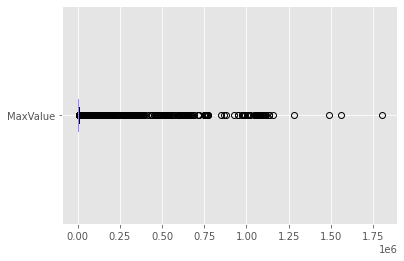

In [42]:
boxplot = data.loc[(data['MetricId'] == 'CpuUsageMHz' )].boxplot(column=['MaxValue'], vert = False)

### VMWare documentatie
Ik weet niet heel veel van VMs dus ik heb de documentatie van VMWare geraadpleegd. De ondergrens is gedefinieerd op 20% CPU workload en de bovengrens op 80%.

**CPU Workload:** *This metric indicates the CPU workload % for the VM, the maximum threshold for this is 80% and the minimum threshold is 20%. If your Maximum line is constantly ~100% flat, you may have a runaway process. If this chart is below or less than 20% all the time for the entire month, then all the large VMs are oversized. This number must hover around 40%, indicating the sizing done was accurate.*

https://docs.vmware.com/en/vRealize-Operations-Manager/8.4/com.vmware.vcom.metrics.doc/GUID-1322F5A4-DA1D-481F-BBEA-99B228E96AF2.html

In onderstaande grafiek is te zien dat een aantal VMs regelmatig boven de bovengrens zit en een aantal zelfs constant.

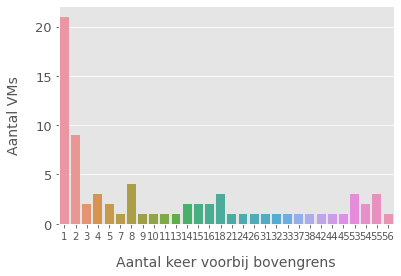

In [51]:
sns.countplot(x = data.loc[(data['AvgValue'] > 0.8 * data['CpuMHz']) & (data['MetricId'] == 'CpuUsageMHz')].groupby(['VMName']).size())

plt.xlabel('Aantal keer voorbij bovengrens', size=14, labelpad=14)
plt.ylabel('Aantal VMs', size=14, labelpad=14)
plt.tick_params(axis='x')
plt.tick_params(axis='y', labelsize=13)


plt.show()

## Advies CPU verlagen

Er wordt alleen gewerkt met de CPU meetgegevens.
Als een VM constant een CPU workload heeft van lager dan 20% dan wordt deze gezien als oversized.

In [60]:
cpuData = data.loc[(data['MetricId'] == 'CpuUsageMHz' )].copy()
cpuData.head()

,VMName,Cluster,time,AvgValue,MinValue,MaxValue,MetricId,MemoryMB,CpuMHz,NumCpu
1,ITLT4301,1,1-5-2018,98.944375,29.343545,673.067569,CpuUsageMHz,0,5600,2
3,ITLT4301,1,2-5-2018,114.670983,30.260531,840.875968,CpuUsageMHz,0,5600,2
5,ITLT4301,1,3-5-2018,121.061228,32.094503,906.898945,CpuUsageMHz,0,5600,2
7,ITLT4301,1,4-5-2018,119.882602,33.928474,690.490299,CpuUsageMHz,0,5600,2
9,ITLT4301,1,5-5-2018,125.255574,35.762446,728.086716,CpuUsageMHz,0,5600,2


In [62]:
# onder de 20% cpu load wordt gezien als oversized VM
cpuData['Oversized'] = 0
cpuData.loc[cpuData.MaxValue <= 0.2 * cpuData.CpuMHz ,'Oversized']= 1


In [64]:
# Alleen als de CPU voor elk meetmoment onder de 20% zit dan wordt de VM gezien als oversized.
Oversized = cpuData.groupby(['VMName']).agg({'Oversized': ['count', 'sum']})
Oversized.columns = ['VMName', 'Oversized']
Oversized['RecommendDownScaling'] = 0
Oversized.loc[Oversized.VMName == Oversized.Oversized ,'RecommendDownScaling']= 1
Oversized

,VMName,Oversized,RecommendDownScaling
VMName,,,
ITLT1000,55,44,0
ITLT1001,53,30,0
ITLT1002,54,0,0
ITLT1003,53,53,1
ITLT1004,59,59,1
...,...,...,...
ITLT5260,55,54,0
ITLT5261,54,52,0
ITLT5262,54,15,0


De lijst met VMs wordt geëxporteerd naar een CSV bestand. 1 betekent dat de VM oversized is en verlaagd zou kunnen worden en 0 betekent dat de VM een juiste configuratie heeft of undersized is. 1228 VMs komen in aanmerking voor downscaling.

In [66]:
Oversized['RecommendDownScaling'].to_csv('/Data/RecommendDownScaling.csv')